# AirBnB Kaggle Competition

Predicting in which country a new user will make their first apartment bookings using the AirBnB data provided during their Kaggle Competition.

In [192]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

Once we have imported all the necessary packages. Let's load the data:

In [193]:
path = "D:/Google Drive/AiRBnB_kaggleComp/"
trainDF = pd.read_csv(path + 'train_users_2.csv')
testDF = pd.read_csv(path + 'test_users.csv')
df = pd.concat([trainDF, testDF])

trainDF.df_name = 'Training Data'
testDF.df_name = 'Test Data'
print('The number of observations in training data:', len(trainDF))
print('The number of observations in test data:', len(testDF))
print('Total number of observations:', len(df))

The number of observations in training data: 213451
The number of observations in test data: 62096
Total number of observations: 275547


The column __`country_destination`__ is the output (dependent) variable which we're going to predict. Let's see the categories in it (different destinations) and the number of observations in each category. The output variable is the last column in the training data ->  we can use `iloc[:, -1]` indexing to get it.

In [358]:
df2 = pd.concat([trainDF.iloc[:, -1].value_counts(), np.round(trainDF.iloc[:, -1].value_counts() / len(trainDF) * 100, 2)],
                axis=1)
df2.columns = ['count', 'percent']
print(df2)

        count  percent
NDF    124543    58.35
US      62376    29.22
other   10094     4.73
FR       5023     2.35
IT       2835     1.33
GB       2324     1.09
ES       2249     1.05
CA       1428     0.67
DE       1061     0.50
NL        762     0.36
AU        539     0.25
PT        217     0.10


Almost 60% of the observations are in the `NDF` category. `NDF` stands for No Destination Found - indicating that there was no booking. Of all the bookings, an overwhelming majority was in the US. `other` is an aggregation of all countries other than those specifically listed.

Let's take a look at some of the data and see which variables have missing values.

In [195]:
print(df.head(9))
print(' .\n', '.\n' , '.\n')
print(df.tail(9))
print('\n', '\n')
print('                   Number of missing values')
print(len(df) - df.count()[df.count() < len(df)])  # columns with missing values

  affiliate_channel affiliate_provider   age country_destination  \
0            direct             direct   NaN                 NDF   
1               seo             google  38.0                 NDF   
2            direct             direct  56.0                  US   
3            direct             direct  42.0               other   
4            direct             direct  41.0                  US   
5             other              other   NaN                  US   
6             other         craigslist  46.0                  US   
7            direct             direct  47.0                  US   
8             other         craigslist  50.0                  US   

  date_account_created date_first_booking first_affiliate_tracked  \
0           2010-06-28                NaN               untracked   
1           2011-05-25                NaN               untracked   
2           2010-09-28         2010-08-02               untracked   
3           2011-12-05         2012-09-08  

In [196]:
print('The number of observations in training data:', len(trainDF))
print('The number of observations in test data:', len(testDF))
print('Total number of observations:', len(df))

The number of observations in training data: 213451
The number of observations in test data: 62096
Total number of observations: 275547


The number of missing values in the __`country_destination`__ column is exactly equal to the number of observations in the test data: $62,096$. That's because this is the variable to be predicted.
So, there are three variables, that we should focus on, with missing values. __`age`__, __`date_first_booking`__ and __`first_affiliate_tracked`__. The latter has relatively very few missing values (only $6,085$ missing out of $275,547$ observations).

Let's take a closer look at __`date_first_booking`__:

In [197]:
for x in (trainDF, testDF):
    print('Number of missing values in {} are {}'.
          format(x.df_name, len(x.date_first_booking) - x.date_first_booking.count()[x.date_first_booking.count() < len(x)][0]))

Number of missing values in Training Data are 124543
Number of missing values in Test Data are 62096


So, the __`date_first_booking`__ column in the test data is all `NaN`. In the training data, the missing values are exactly equal to the number of `NDF`(no booking) observations. This makes sense, if no booking was done, then the date of the first booking for that user is `NaN`. Conclusion: this feature will not be of much help in predicting booking destination and can be dropped.

There are two other columns with timestamps, so we need to convert them into datetime using `pd.to_datetime`.

In [198]:
df.timestamp_first_active = pd.to_datetime(df.timestamp_first_active, format='%Y%m%d%H%M%S')
df.date_account_created = pd.to_datetime(df.date_account_created, format='%Y-%m-%d')
df.dtypes  # check the data types after conversion to datetime

affiliate_channel                  object
affiliate_provider                 object
age                               float64
country_destination                object
date_account_created       datetime64[ns]
date_first_booking                 object
first_affiliate_tracked            object
first_browser                      object
first_device_type                  object
gender                             object
id                                 object
language                           object
signup_app                         object
signup_flow                         int64
signup_method                      object
timestamp_first_active     datetime64[ns]
dtype: object

In [199]:
df = df.loc[:, ['id','affiliate_channel', 'affiliate_provider', 'age', 'date_account_created', 'first_affiliate_tracked',
                'first_browser', 'first_device_type', 'gender', 'language', 'signup_app', 'signup_flow', 'signup_method',
                'timestamp_first_active','country_destination']]

The __`age`__ variable has about 40% missing values. Not many people are willing to provide their age. Moreover, out of the ones that do provide it, the data is entered in different formats: some people have entered their birth year instead of age:

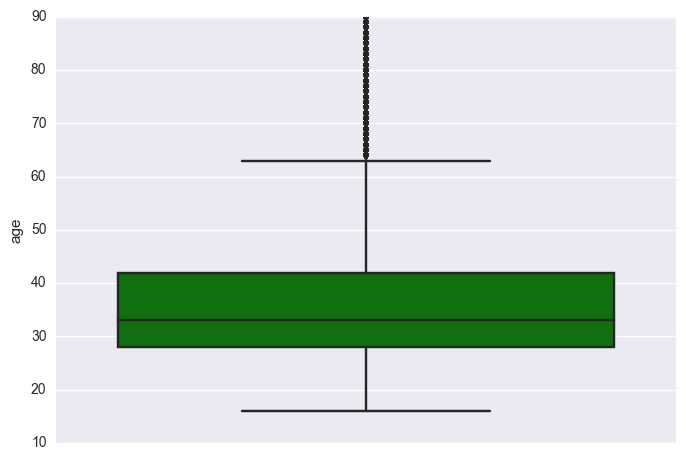

In [332]:
plt.clf()
sns.boxplot(df.age, orient='v', color='g')
plt.show()

We can see on the boxplot above, that there is a bunch of values around the 2000 threshold. Let's plot another boxplot, but now without those values:

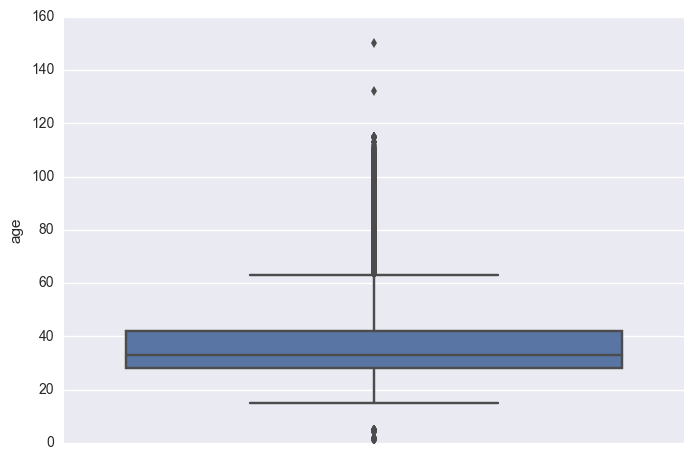

In [170]:
plt.clf()
sns.boxplot(df.age[df.age <= df.age[df.age < 1000].max()], orient='v', color='g')
plt.show()

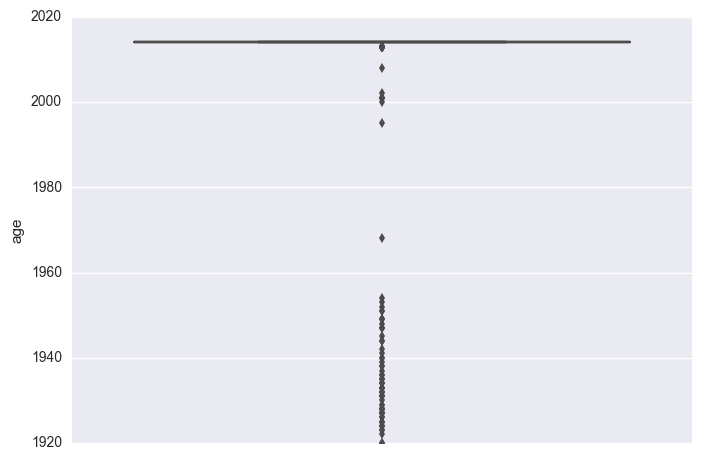

In [174]:
plt.clf()
sns.boxplot(df.age[df.age >= df.age[df.age > 1000].min()], orient='v')
plt.show()

From the boxplot above we can see that some of the extremely high values are birthyears, and many (the ones that are around 2010) are just errors. We can transform the birthyears into ages by subtracting the age (birthyear) value from the year the account was created for those values where the difference is positive. We don't want negative age result (for instance a use registered in 2010 and gave 2014 as their age/birthyear, which would result in 2010 - 2014 = -4):

In [223]:
df.age[(df.age >= 1920) & (df.age < df.date_account_created.dt.year)] = \
    df.date_account_created[(df.age >= 1920) & (df.age < df.date_account_created.dt.year)].dt.year - \
                     df.age[(df.age >= 1920) & (df.age < df.date_account_created.dt.year)]

C:\Users\Rustam\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Let's take a look at the age value counts below age 18 and above age 85 now: 

In [356]:
age_counts = df.age.groupby(df.age).count()
print(age_counts[:18])
age_counts[85:]

age
16.0     39
17.0     81
18.0    824
Name: age, dtype: int64


age
85.0    35
86.0    35
87.0    37
88.0    18
89.0    18
90.0    24
Name: age, dtype: int64

Here, I will make a subjective judgement that, people younger than 16 and older than 90 wouldn't be travelling and booking apartments on AirBnB. Perhaps, I could stretch to 15 - 95 range, but that will only be adding 145 observations (too small a value to make big difference, I suppose).

In [250]:
df.age[df.age < 16] = np.nan
df.age[df.age > 90] = np.nan

C:\Users\Rustam\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Rustam\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Let's take a look at the age distribution by binning the __`age`__ variable:

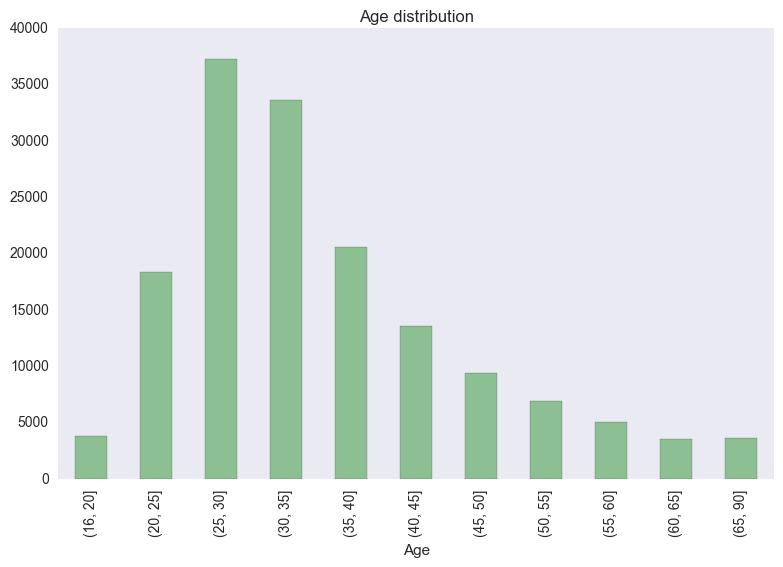

count    155751.000000
mean         35.982517
std          11.467154
min          16.000000
25%          28.000000
50%          33.000000
75%          42.000000
max          90.000000
Name: age, dtype: float64

In [352]:
bins = [df.age.min(), 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, df.age.max()]
df['age_cats'] = pd.cut(df.age, bins)
plt.clf()
df['age_cats'].value_counts(sort=0).plot(kind='bar', color='g', alpha=0.4)
plt.tight_layout()
plt.title('Age distribution')
plt.xlabel('Age')
plt.grid()
plt.show()
df['age'].describe()

The __`age`__ feature is now fixed and we can see from above that half of the users had ages between 28 and 42 (interquartile range).

Let's take a look at other variables in the data:

In [337]:
df.describe(include='all')

,id,affiliate_channel,affiliate_provider,age,date_account_created,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,timestamp_first_active,country_destination,age_cats
count,275547,275547,275547,155751.000000,275547,269462,275547,275547,275547,275547,275547,275547.000000,275547,275547,213451,155712
unique,275547,8,18,NaN,1726,7,55,9,4,26,4,NaN,4,275547,12,11
top,9digp6zuov,direct,direct,NaN,2014-07-23 00:00:00,untracked,Chrome,Mac Desktop,-unknown-,en,Web,NaN,basic,2012-11-02 18:18:42,NDF,"(25, 30]"
freq,1,181571,181270,NaN,1105,143181,78671,106328,129480,265538,219918,NaN,198222,1,124543,37253
first,NaN,NaN,NaN,NaN,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-03-19 04:32:55,NaN,NaN
last,NaN,NaN,NaN,NaN,2014-09-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-09-30 23:59:01,NaN,NaN
mean,NaN,NaN,NaN,35.982517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.291965,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,11.467154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.794313,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,28.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN


The column __`gender`__ has $4$ unique categories according to the table, and the category with the most observations is `-unknown-`. Let's look at the gender breakdown of the users: 

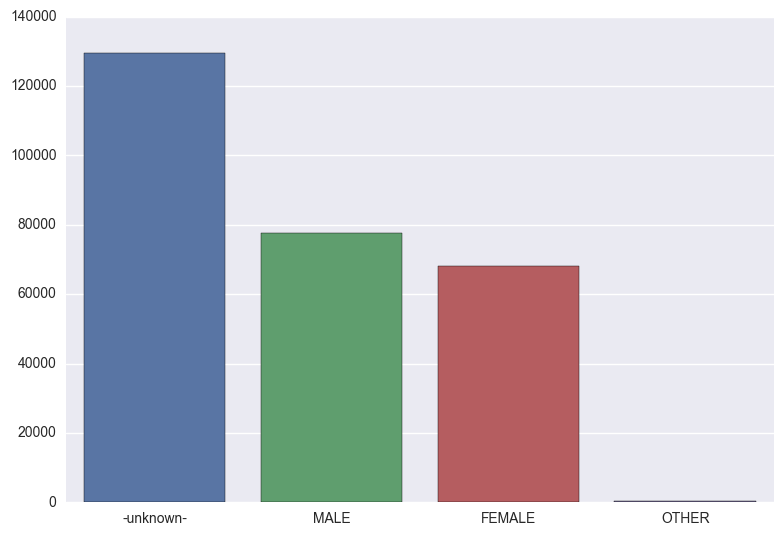

In [373]:
sns.barplot(df.gender.unique(), df.gender.value_counts())
plt.ylabel('')
plt.tight_layout()
plt.show()

In [276]:
df.columns


Index(['id', 'affiliate_channel', 'affiliate_provider', 'age',
       'date_account_created', 'first_affiliate_tracked', 'first_browser',
       'first_device_type', 'gender', 'language', 'signup_app', 'signup_flow',
       'signup_method', 'timestamp_first_active', 'country_destination',
       'age_cats'],
      dtype='object')

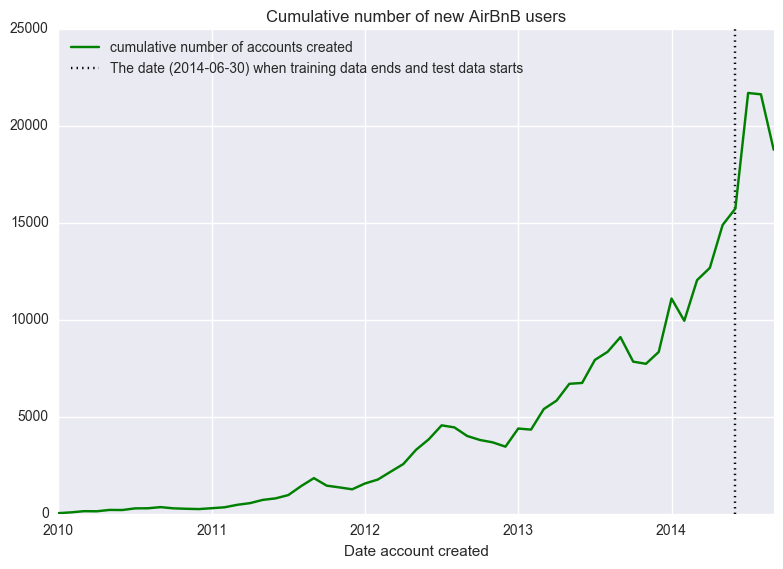

In [360]:
accounts_created = pd.DataFrame(df.date_account_created.value_counts())
accounts_created.date_account_created.resample('m').sum().plot(label='cumulative number of accounts created', color='g')
plt.vlines('2014-06-30', ymin=0, ymax=25000, linestyles='dotted',
           label='The date (2014-06-30) when training data ends and test data starts')
plt.tight_layout()
plt.title('Cumulative number of new AirBnB users')
plt.legend(loc='upper left')
plt.xlabel('Date account created')
plt.show()